Maybe easier to follow https://pytorch.org/tutorials/beginner/chatbot_tutorial.html?highlight=chatbot%20tutorial

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
import numpy as np
from io import open
import itertools
import math
import matplotlib.pyplot as plt
%matplotlib inline


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

/home/nsk367/anaconda3/envs/irl/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
print(device)

cpu


In [3]:
corpus_name = "cornell movie-dialogs corpus"
corpus = os.path.join("../dat/", corpus_name)

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

#printLines(os.path.join(corpus, "movie_lines.txt"))


In [4]:
# Splits each line of the file into a dictionary of fields
def loadLines(fileName, fields):
    lines = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[lineObj['lineID']] = lineObj
    return lines


# Groups fields of lines from `loadLines` into conversations based on *movie_conversations.txt*
def loadConversations(fileName, lines, fields):
    conversations = []
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            # Convert string to list (convObj["utteranceIDs"] == "['L598485', 'L598486', ...]")
            utterance_id_pattern = re.compile('L[0-9]+')
            lineIds = utterance_id_pattern.findall(convObj["utteranceIDs"])
            # Reassemble lines
            convObj["lines"] = []
            for lineId in lineIds:
                convObj["lines"].append(lines[lineId])
            conversations.append(convObj)
    return conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations:
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs


# Extracts cleaned dialogue sentences from conversations
def extractConversation(conversations):
    clean_conversation = []
    for conversation in conversations:
        convo = []
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"])):  # We ignore the last line (no answer for it)
            Line = conversation["lines"][i]["text"].strip()
            convo.append(Line)
        if len(convo) > 2: #there has to be a reply? 
            clean_conversation.append(convo)

    return clean_conversation

In [5]:
# Define path to new file

datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict, conversations list, and field ids
lines = {}
conversations = []
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]

# Load lines and process conversations
print("\nProcessing corpus...")
lines = loadLines(os.path.join(corpus, "movie_lines.txt"), MOVIE_LINES_FIELDS)
print("\nLoading conversations...")
conversations = loadConversations(os.path.join(corpus, "movie_conversations.txt"),
                                  lines, MOVIE_CONVERSATIONS_FIELDS)

convos = extractConversation(conversations)
# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)


    


Processing corpus...

Loading conversations...

Writing newly formatted file...


In [65]:
# Little bit of eda.. 
convo_lengths = []
utterance_lengths = []
for convo in convos:
    conversation_length = len(convo)
    if conversation_length > 2:
 #       print(convo)
        convo_lengths.append(conversation_length)
        for sentence in convo:
            utterance_lengths.append(len(sentence.split(' ')))

Text(0, 0.5, 'Frequency')

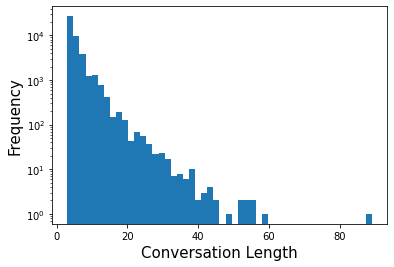

In [66]:
plt.hist(convo_lengths,bins=50)
plt.yscale('log')
plt.xlabel('Conversation Length',fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)

In [69]:
convo

['Well I assure you, Sir, I have no desire to create difficulties. 45',
 "And I assure you, you do not In fact I'd be obliged for your best advice. What have your scouts seen?",
 'So far only their scouts. But we have had reports of a small Impi farther north, over there.']

Text(0, 0.5, 'Frequency')

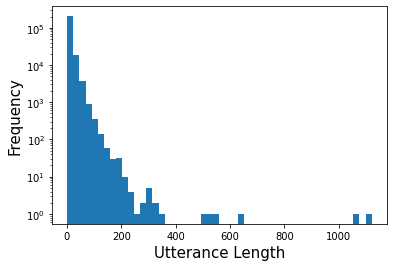

In [68]:
plt.hist(utterance_lengths,bins=50)
plt.yscale('log')
plt.xlabel('Utterance Length',fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)

In [73]:
class DialogEnvironment(object):
    """
    
    Gym environment for dialog.
    
    """
    def __init__(self, mode='train'):
        

        self.conversations = extractConversation(conversations)
        
    
        if mode == 'train':
            self.conversations = self.conversations[:-10]
        elif mode == 'test':
            self.conversations = self.conversations[-10]
            
        
        self.conversations_visited = []
        
    def clear(self):
        self.conversations_visited = [] #
    def current_state(self):
        return i,j # i for current conversation index, j for current word (these should be odd? )
    
    def reset(self):
        # pick a random i in length of convos. If in convos visited, skip
        
        self.i = random.randint(a=0,b=len(self.conversations))
        
        
        self.conversations_visited.append(self.i)
        self.conversation = self.conversations[self.i]
        self.j = 0
        state = self.conversation[self.j]
        return state
    def step(self,action):
        done = False
        self.j +=2 
        new_state = self.conversation[self.j]
        
        if new_state in self.conversation[-2:]: # if this last obs was either the last or second last thing, end here. 
            done = True
        
        return new_state, done


In [74]:
env.conversation[env.j - 1]

'Those sounds could be imitated.'

In [75]:
env = DialogEnvironment()

In [76]:
i = 0
while i < 5:
    state  = env.reset()
    print("~~~~~~~~~~~~~~~~~ New Episode ~~~~~~~~~~~~~~")
    print('first state : ', state)
    while True:
     #   action = "Fuck that, I'm not even supposed to be here "
        action = env.conversation[env.j - 1] #it's already a part of the env,
        print("agent action : ", action)
        new_state, done = env.step(action)
#        print("agent action : ", expert_action, env.j)
        print("next state : ", new_state)
        if done:
            break

    i += 1

~~~~~~~~~~~~~~~~~ New Episode ~~~~~~~~~~~~~~
first state :  Your West Virginia specimen gave us quite a bit of trouble, but I finally managed to narrow his species through chaetaxy - studying the skin.
agent action :  Just ignore him. He's not a Ph.D.
next state :  Just ignore him. He's not a Ph.D.
~~~~~~~~~~~~~~~~~ New Episode ~~~~~~~~~~~~~~
first state :  Nice to meet you, Wally.
agent action :  Tell me how all this works.
next state :  Tell me how all this works.
~~~~~~~~~~~~~~~~~ New Episode ~~~~~~~~~~~~~~
first state :  If there was one nearby I'd probably ask him.
agent action :  Whatever the hell we are, we should quit and go get ourselves some real employment.
next state :  Handymen, Earl.  We're handymen.
~~~~~~~~~~~~~~~~~ New Episode ~~~~~~~~~~~~~~
first state :  Maybe you can talk sense into your boyfriend.
agent action :  
next state :  
~~~~~~~~~~~~~~~~~ New Episode ~~~~~~~~~~~~~~
first state :  I'm not going to be the scapegoat for this.  Haldeman and Ehrlichman are in ju

# TODO:

Get the word embeddings for these sentences. Should there be padding? If it's fixed sequence, may be easier to train on.

After that's all figured out, conduct IRL. 

sequence length = 20: 

=> -- some fine tuned word language model, getting the best representation possible for this corpus

Why are you laughing? => [1x200, 1x200, 1x200 1x200 , 1x200,   .... MAX_LENGTH] , some form of token padding 

rather than vectorized form, 

the network always aceepts the same input shape, which here is like [ Maxlengnth x 1 x 200]

from this, it emits an action, which is then [action_maxlenth x 1 x 200]


using the action, the environment then emits the new state, of dimension [ Maxlengnth x 1 x 200]


So how does RL come into play here? 


Even though the environment above is fixed,we know how the "expert" behaves when running through it. 




GAIL: 

